# Lab 7: RC Snubber and Clamp Testing

#### Andrew Phillips

## Prelab: Design Clamp and Snubber

In this prelab, I calculated and specced values for an RCD clamp to limit the max voltage ring in our lab hardware and an RC snubber to increase the damping of the lab hardware. The RCD clamp is designed to allow the use of a MOSFET rated for 60V, while the RC snubber is designed to give the system a damping ratio of 0.7. These capacitor and resistor values are calculated in the code block below.

The converter's fast ring is a result of the leakage inductance of the transformer resonating with the parasitic capacitances of the circuit, while the slow ring is due to the primary inductance of the transformer resonating with the same parasitic capacitances. The appropriate inductances are used in the code block below. The leakage inductance of the transformer was measured by shorting the secondary winding of the transformer and measuring the primary inductance on the LCR meter.

For the clamp calculations, I decided to design for maximum voltage of 38V, to provide a factor of safety between the max voltage present in the circuit and the max voltage the FET is rated for.

In [11]:
from math import pi, sqrt, log

# parameters calculated from lab 6
L = 18e-6 # inductance of primary transformer winding
z_des = 0.7 # desired damping ratio
L_leak = 0.89e-6 # in H, measured on LCR meter

# fast ring snubber

# parameters calculated from lab 6
wd_fast_hz = 14.71e6 # Damped natural frequency in Hz
wd_fast = wd_fast_hz*2*pi # convert to rad/s
z_fast = 0.041 # actual damping ratio w/o snubber

# calculate transformer parasitic capacitance
c_tr_fast = 1/(L_leak*wd_fast**2)
print("Fast ring transformer parasitic capacitance:",c_tr_fast)

# calculate snubber capacitance, 3 times c
c_sb_fast = c_tr_fast*3
print("Fast ring snubber capacitance:",c_sb_fast)

# calculate snubber resistance for desired damping ratio, 0.7
r_sb_fast = (z_des*2)/sqrt(c_sb_fast/L_leak)
print("Fast ring snubber resistance:",r_sb_fast)

# slow ring snubber

# parameters calculated from lab 6
wd_slow_hz = 1.19e6 # Damped natural frequency in Hz
wd_slow = wd_slow_hz*2*pi # convert to rad/s
z_slow = 0.058 # actual damping ratio w/o snubber

# calculate transformer parasitic capacitance
c_tr_slow = 1/(L*wd_slow**2)
print("Slow ring transformer parasitic capacitance:",c_tr_slow)

# calculate snubber capacitance, 3 times c
c_sb_slow = c_tr_slow*3
print("Slow ring snubber capacitance:",c_sb_slow)

# calculate snubber resistance for desired damping ratio, 0.7
r_sb_slow = (z_des*2)/sqrt(c_sb_slow/L)
print("Slow ring snubber resistance:",r_sb_slow)

# Clamp

# Define max allowable clamp voltage:
Vg = 18 # V
Vmax = 38 # V
Vcp = Vmax-Vg # Clamp voltage
Vo = 10
a = 0.816 # Calculated in lab 6
V = Vo/a

# Calculate peak clamp current
Rsh = 0.05 # Ohms
vpk_9 = 0.3264 # Peak voltage across shunt resistor at 9.04V output from Lab 6
ipk_9 = vpk_9/Rsh
print("Peak current at 9.04V output:",ipk_9)
ipk = ipk_9*10/9 # kinda fudging this for 10V output approximation
print("Peak current at 10V output:",ipk)

# Determine average power absorbed by clamp
Kcp = Vcp/V

fs = 50e3 # switching frequency in Hz
Ts = 1/fs # switching period

#P_avg = 1/(2*Ts)*ipk**2*L_leak*1/(1-(1/Kcp))
P_avg = 20 #W
print("Average power absorbed by clamp:",P_avg)

# Calculate clamp resistance
Rcp = Vcp**2/P_avg
print("Clamp resistance:",Rcp)

# Calculate clamp capacitance
V_ripple = 0.8 # %
Ccp = 1/(Rcp*V_ripple)*(Ts-ipk*(L_leak+L)/(Vcp-V))
print("Clamp capacitance:",Ccp)

Fast ring transformer parasitic capacitance: 1.3153002758107513e-10
Fast ring snubber capacitance: 3.945900827432254e-10
Fast ring snubber resistance: 66.48902371053026
Slow ring transformer parasitic capacitance: 9.937424346438356e-10
Slow ring snubber capacitance: 2.9812273039315068e-09
Slow ring snubber resistance: 108.78443066931145
Peak current at 9.04V output: 6.5280000000000005
Peak current at 10V output: 7.253333333333334
Average power absorbed by clamp: 20
Clamp resistance: 20.0
Clamp capacitance: 1.4433721518987328e-07


Based on these calculations, I selected component values from the available capacitor and resistor values that were close to my calculations. From testing in the lab session, we found that the fast ring snubber works more effectively with a lower resistor value, so this was adjusted during the lab sessions. The final selected component values are listed below for each component:

Fast Ring RC Snubber:
- Rsb: 10 Ohms
- Csb: 1nF

Slow Ring RC Snubber:
- Rsb: 100 Ohms
- Csb: 3.3nF

RCD Clamp:
- Diode: BYV27-100-TAP
- Rcp: 22 Ohms
- Ccp: 0.15uF

To verify these calculations, I simulated each of these components in my digital twin, which I updated to include parasitic capacitances from the transformer and FET and leakage inductances from the transformer. This twin has been included in the submission, and screenshots of the circuit and waveforms are included below. In each of the waveform captures, the top trace is the FET drain voltage, while the bottom trace is the current through the transformer's modelled inductor.

Circuit Overview:

![plecs_prelab](images/plecs_prelab.png)

Waveforms with no clamp or snubber:

![no_components](images/no_components.png)

Waveforms with fast ring snubber:

![fast_ring_snubber](images/fast_ring_snubber.png)

Waveforms with slow ring snubber:

![slow_ring_snubber](images/slow_ring_snubber.png)

Waveforms with clamp:

![clamp](images/clamp.png)

As can be seen from the waveforms, the fast and slow snubbers effectively introduce much more damping into the system for their respective waveforms, while the clamp effectively limits the voltage across the FET below 60V.

## Data Collection

In the lab session, Suki and I tested the components for both snubbers and the RCD clamp. Without the snubber or clamp, we increased the output voltage until it reached 10V. This resulted in a peak Vdrain of 72.8V. From there, we captured drain and shunt voltage waveforms for the fast and slow oscillations for each snubber. For the clamp, We added another probe to measure the cathode voltage through the RCD clamp. 

In [12]:
# Plotting
# import necessary python libraries
import pandas as pd
import matplotlib.pyplot as plt
import csv

# read funky Rigol CSV format
def read_rigol_csv(csv_file_name):
    with open(csv_file_name) as f:
        rows = list(csv.reader(f))
        i = 0
        while rows[0][i] != "":
            i = i+1
        numcols = i-2
        t0 = float(rows[1][numcols])
        dT = float(rows[1][numcols+1])
    data = pd.read_csv(csv_file_name, usecols=range(0,numcols), skiprows=[1])
    data['X'] = t0+data['X']*dT
    return data, t0, dT

calculated slow resonant frequency: 1176470.5882352937
Peak voltage: 72.8
calculated fast resonant frequency: 14285714.285714768


Text(0.5, 1.0, 'Baseline Shunt Voltage at 10.26V Output')

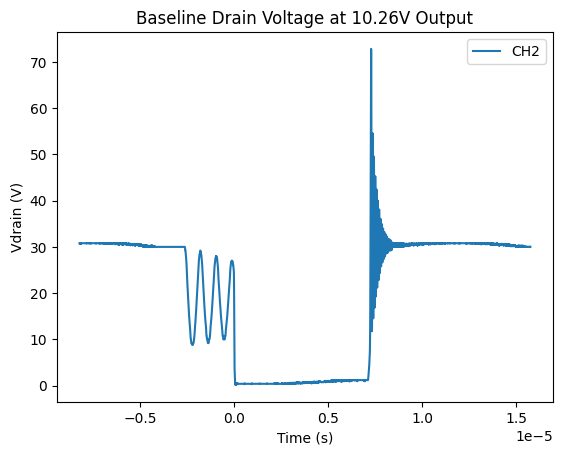

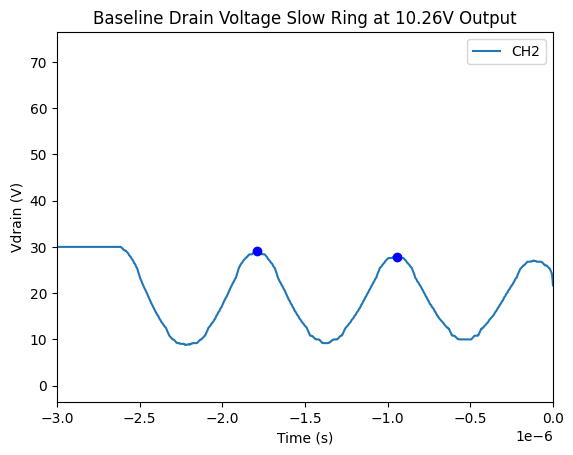

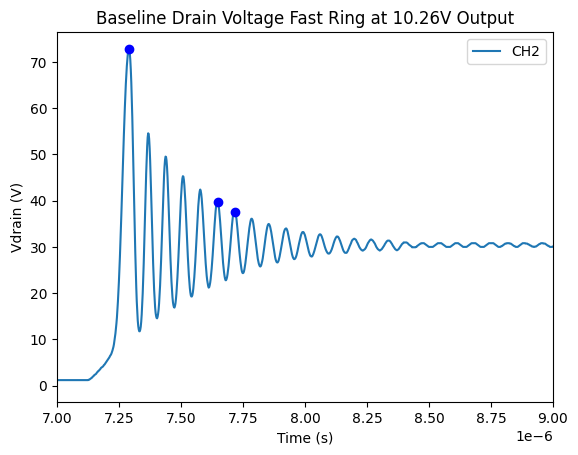

In [13]:
Vin = 18.02 #V
Vobl = 10.26 #V

# baseline
[baseline_data, baseline_data_t0, baseline_data_dT] = read_rigol_csv('data/baseline.csv')

# apply data filter
baseline_data['CH1'] = baseline_data['CH1'].rolling(10).mean()
baseline_data['CH2'] = baseline_data['CH2'].rolling(10).mean()

# plot drain voltage
fig, ax = plt.subplots()
baseline_data.plot(x="X", y="CH2", ax = ax)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Vdrain (V)")
ax.set_title("Baseline Drain Voltage at 10.26V Output")

# plot slow ring
fig, ax = plt.subplots()
baseline_data.plot(x="X", y="CH2", ax = ax)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Vdrain (V)")
ax.set_title("Baseline Drain Voltage Slow Ring at 10.26V Output")
ax.set_xlim((-0.3e-5,0.0e-5))

# Calculate resonant frequency
ax.plot(baseline_data['X'].get(3650), baseline_data['CH2'].get(3650), "bo")
ax.plot(baseline_data['X'].get(3225), baseline_data['CH2'].get(3225), "bo")
slow_freq = 1/(baseline_data['X'].get(3650)-baseline_data['X'].get(3225))
print("calculated slow resonant frequency:", slow_freq)

# plot fast ring
fig, ax = plt.subplots()
baseline_data.plot(x="X", y="CH2", ax = ax)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Vdrain (V)")
ax.set_title("Baseline Drain Voltage Fast Ring at 10.26V Output")
ax.set_xlim((0.7e-5,0.9e-5))
ax.plot(baseline_data['X'].get(7765), baseline_data['CH2'].get(7765), "bo")
#print("Peak voltage:",baseline_data["CH2"].get(7765))
print("Peak voltage:",max(baseline_data["CH2"][7500:8000]))

# Calculate resonant frequency
ax.plot(baseline_data['X'].get(7945), baseline_data['CH2'].get(7945), "bo")
ax.plot(baseline_data['X'].get(7980), baseline_data['CH2'].get(7980), "bo")
fast_freq = 1/(baseline_data['X'].get(7980)-baseline_data['X'].get(7945))
print("calculated fast resonant frequency:", fast_freq)

# plot shunt voltage
fig, ax = plt.subplots()
baseline_data.plot(x="X", y="CH1", ax = ax)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Vshunt (V)")
ax.set_title("Baseline Shunt Voltage at 10.26V Output")

calculated slow resonant frequency: 657894.7368421053
Low frequency ring damping ratio: 0.6450035922057


Text(0.5, 1.0, 'Slow Snubber Shunt Voltage at 10.26V Output')

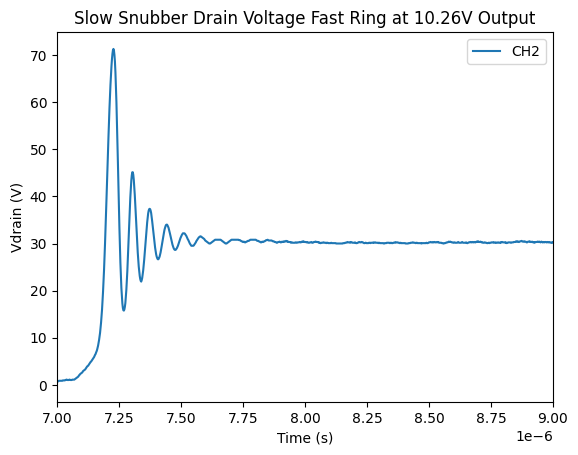

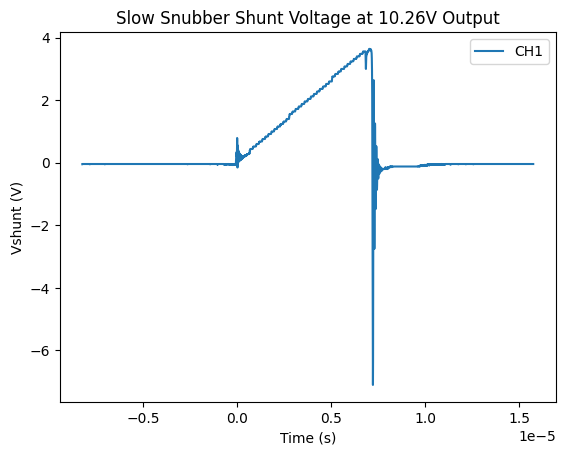

In [14]:
# slow snubber
# baseline
[slow_snub, slow_snub_t0, slow_snub_dT] = read_rigol_csv('data/slow_snubber.csv')

# apply data filter
slow_snub['CH1'] = slow_snub['CH1'].rolling(10).mean()
slow_snub['CH2'] = slow_snub['CH2'].rolling(10).mean()

# plot drain voltage
fig, ax = plt.subplots()
slow_snub.plot(x="X", y="CH2", ax = ax)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Vdrain (V)")
ax.set_title("Slow Snubber Drain Voltage at 10.26V Output")
# ax.plot(baseline_data['X'].get(8500), baseline_data['CH2'].get(8500), "bo")

# plot slow ring
fig, ax = plt.subplots()
slow_snub.plot(x="X", y="CH2", ax = ax)
# baseline_data.plot(x="X", y="CH2", ax = ax)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Vdrain (V)")
ax.set_title("Slow Snubber Drain Voltage Slow Ring at 10.26V Output")
ax.set_xlim((-0.3e-5,0.0e-5))

# estimate where next minima is
next_max = 3040 + (3420-3040)*2

# Calculate resonant frequency
ax.plot(slow_snub['X'].get(3420), slow_snub['CH2'].get(3420), "bo")
ax.plot(slow_snub['X'].get(3040), slow_snub['CH2'].get(3040), "bo")
slow_freq = 1/(slow_snub['X'].get(next_max)-slow_snub['X'].get(3040))
print("calculated slow resonant frequency:", slow_freq)

# Calculate damping ratio
#print(slow_snub['CH2'].get(next_max))
#print(slow_snub['CH2'].get(3420))
Vpk = Vin
phi_low = log((slow_snub['CH2'].get(3040)-Vpk)/(slow_snub['CH2'].get(next_max)-Vpk))
damp_ratio_low = 1/sqrt(1+((2*pi)/phi_low)**2)
print("Low frequency ring damping ratio:",damp_ratio_low)

# plot fast ring
fig, ax = plt.subplots()
slow_snub.plot(x="X", y="CH2", ax = ax)
# baseline_data.plot(x="X", y="CH2", ax = ax)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Vdrain (V)")
ax.set_title("Slow Snubber Drain Voltage Fast Ring at 10.26V Output")
ax.set_xlim((0.7e-5,0.9e-5))

# plot shunt voltage
fig, ax = plt.subplots()
slow_snub.plot(x="X", y="CH1", ax = ax)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Vshunt (V)")
ax.set_title("Slow Snubber Shunt Voltage at 10.26V Output")

calculated fast damped frequency: 9090909.090909317
High frequency ring damping ratio: 0.2395792272651885


Text(0.5, 1.0, 'Fast Snubber Shunt Voltage at 10.26V Output')

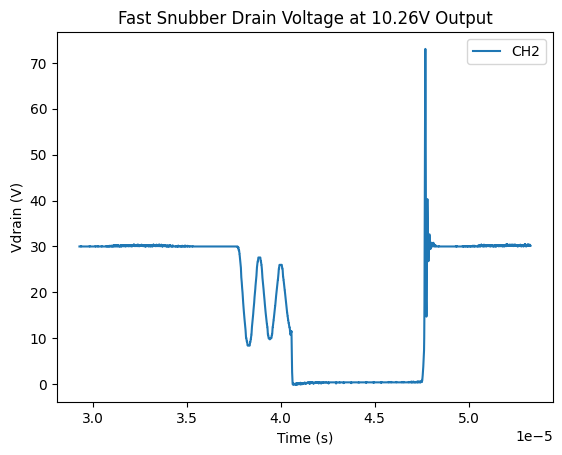

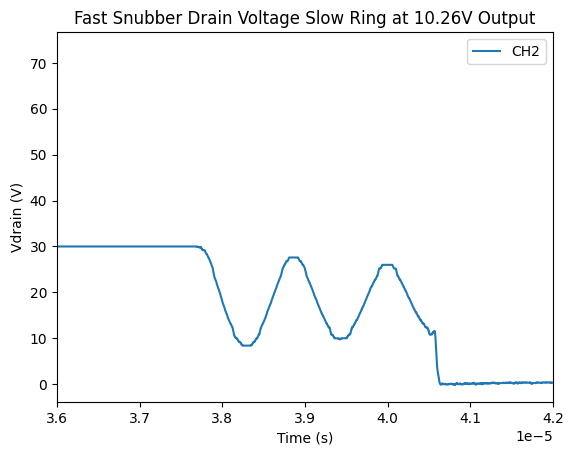

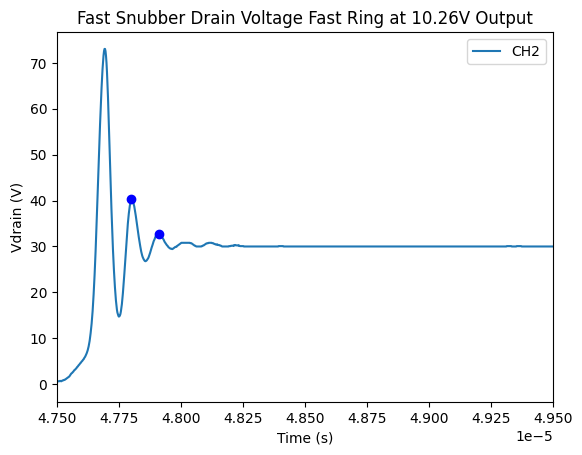

In [15]:
# fast snubber
# baseline
[fast_snub_2, fast_snub_2_t0, fast_snub_2_dT] = read_rigol_csv('data/fast_snubber_2.csv')

# apply data filter
fast_snub_2['CH1'] = fast_snub_2['CH1'].rolling(10).mean()
fast_snub_2['CH2'] = fast_snub_2['CH2'].rolling(10).mean()

# plot drain voltage
fig, ax = plt.subplots()
fast_snub_2.plot(x="X", y="CH2", ax = ax)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Vdrain (V)")
ax.set_title("Fast Snubber Drain Voltage at 10.26V Output")
# ax.plot(baseline_data['X'].get(8500), baseline_data['CH2'].get(8500), "bo")

# plot slow ring
fig, ax = plt.subplots()
fast_snub_2.plot(x="X", y="CH2", ax = ax)
#baseline_data.plot(x="X", y="CH2", ax = ax)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Vdrain (V)")
ax.set_title("Fast Snubber Drain Voltage Slow Ring at 10.26V Output")
ax.set_xlim((3.6e-5,4.2e-5))

# plot fast ring
fig, ax = plt.subplots()
fast_snub_2.plot(x="X", y="CH2", ax = ax)
#baseline_data.plot(x="X", y="CH2", ax = ax)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Vdrain (V)")
ax.set_title("Fast Snubber Drain Voltage Fast Ring at 10.26V Output")
ax.set_xlim((4.75e-5,4.95e-5))
ax.plot(fast_snub_2['X'].get(9260), fast_snub_2['CH2'].get(9260), "bo")
ax.plot(fast_snub_2['X'].get(9315), fast_snub_2['CH2'].get(9315), "bo")

# calculate damped frequency
fast_snub_freq = 1/(fast_snub_2['X'].get(9315)-fast_snub_2['X'].get(9260))
print("calculated fast damped frequency:", fast_snub_freq)

# calculate damping ratio
Vpk = Vin+Vobl/a
phi_high = log((fast_snub_2['CH2'].get(9260)-Vpk)/(fast_snub_2['CH2'].get(9315)-Vpk))
damp_ratio_high = 1/sqrt(1+((2*pi)/phi_high)**2)
print("High frequency ring damping ratio:",damp_ratio_high)


# plot shunt voltage
fig, ax = plt.subplots()
fast_snub_2.plot(x="X", y="CH1", ax = ax)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Vshunt (V)")
ax.set_title("Fast Snubber Shunt Voltage at 10.26V Output")


Peak voltage: 4.28
Max Voltage across C16: 36.68
Min Voltage across C16: 18.359999999999996
Ripple: 0.499454743729553
Calculated Value of Differential Capacitor: 1.418289233545687e-07


/tmp/ipykernel_6180/3675303796.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clamp_curve["CH3"] = clamp_curve["CH3"] - Vg # remove input voltage offset
/tmp/ipykernel_6180/3675303796.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clamp_curve["X"] = clamp_curve["X"] - clamp["X"].get(1500)


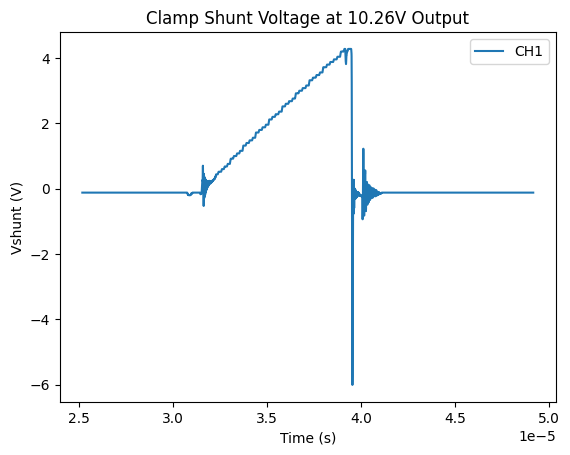

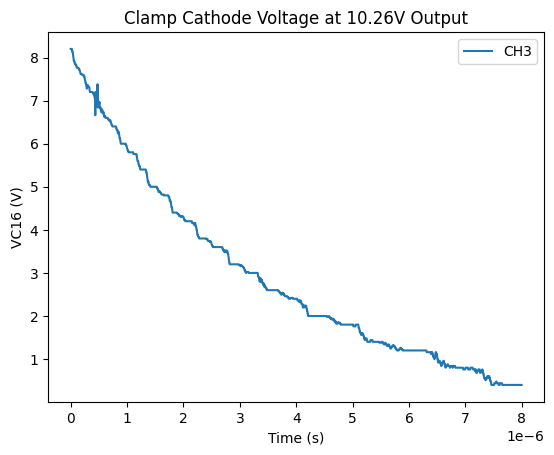

In [20]:
from scipy.optimize import curve_fit
from numpy import exp

# clamp
# fast snubber
# baseline
[clamp, clamp_t0, clamp_dT] = read_rigol_csv('data/clamp.csv')

# apply data filter
clamp['CH1'] = clamp['CH1'].rolling(10).mean()
clamp['CH2'] = clamp['CH2'].rolling(10).mean()
clamp['CH3'] = clamp['CH3'].rolling(10).mean()

# plot drain voltage
fig, ax = plt.subplots()
clamp.plot(x="X", y="CH2", ax = ax)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Vdrain (V)")
ax.set_title("Clamp Drain Voltage at 10.26V Output")
ax.plot(clamp['X'].get(5600), clamp['CH2'].get(5600), "bo")
ax.plot(clamp['X'].get(500), clamp['CH2'].get(500), "bo")

# plot shunt voltage
fig, ax = plt.subplots()
clamp.plot(x="X", y="CH1", ax = ax)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Vshunt (V)")
ax.set_title("Clamp Shunt Voltage at 10.26V Output")
print("Peak voltage:",max(clamp["CH1"][500:7000]))

# plot cathode voltage
fig, ax = plt.subplots()
clamp.plot(x="X", y="CH3", ax = ax)
ax.set_xlabel("Time (s)")
ax.set_ylabel("VC16 (V)")
ax.set_title("Clamp Cathode Voltage at 10.26V Output")

VC16max = clamp["CH3"].max()
print("Max Voltage across C16:",VC16max)
VC16min = clamp["CH3"].min()
print("Min Voltage across C16:",VC16min)
Ripple = (VC16max-VC16min)/VC16max
print("Ripple:",Ripple)

# curve fit
clamp_curve = clamp.iloc[1500:3500] # isolate exponential
clamp_curve["CH3"] = clamp_curve["CH3"] - Vg # remove input voltage offset
clamp_curve["X"] = clamp_curve["X"] - clamp["X"].get(1500)
fig, ax = plt.subplots()
clamp_curve.plot(x="X", y="CH3", ax = ax)
ax.set_xlabel("Time (s)")
ax.set_ylabel("VC16 (V)")
ax.set_title("Clamp Cathode Voltage at 10.26V Output")

# define exponential function
def func(x, a, b):
    return a*exp(b*x)

constants, values = curve_fit(func, clamp_curve["X"], clamp_curve["CH3"])

Rcp = 22 # actual value

Ccp_calc = -1/(Rcp*constants[1])
print("Calculated Value of Differential Capacitor:",Ccp_calc)

## Post-Lab Analysis

#### Baseline Analysis

9. Based on the captured waveforms, I calculated a resonant frequency of 14.28 MHz for the fast ring and 1.18 MHz for the slow ring. This is calculated in the code blocks above.

10. The snubber values are recalculated below with the frequencies calculated above. The fast and slow snubber calculations are very similar to my prelab calculations, verifying my LCR values.

In [ ]:
# recalculate snubber values
wd_fast_hz_lab = 14.28e6
wd_slow_hz_lab = 1.18e6
wd_fast_lab = wd_fast_hz_lab*2*pi
wd_slow_lab = wd_slow_hz_lab*2*pi

# fast ring

# calculate transformer parasitic capacitance
c_tr_fast = 1/(L_leak*wd_fast_lab**2)
print("Fast ring transformer parasitic capacitance:",c_tr_fast)

# calculate snubber capacitance, 3 times c
c_sb_fast = c_tr_fast*3
print("Fast ring snubber capacitance:",c_sb_fast)

# calculate snubber resistance for desired damping ratio, 0.7
r_sb_fast = (z_des*2)/sqrt(c_sb_fast/L_leak)
print("Fast ring snubber resistance:",r_sb_fast)

# slow ring

# calculate transformer parasitic capacitance
c_tr_slow = 1/(L*wd_slow_lab**2)
print("Slow ring transformer parasitic capacitance:",c_tr_slow)

# calculate snubber capacitance, 3 times c
c_sb_slow = c_tr_slow*3
print("Slow ring snubber capacitance:",c_sb_slow)

# calculate snubber resistance for desired damping ratio, 0.7
r_sb_slow = (z_des*2)/sqrt(c_sb_slow/L)
print("Slow ring snubber resistance:",r_sb_slow)


Fast ring transformer parasitic capacitance: 1.3957056666346008e-10
Fast ring snubber capacitance: 4.187116999903802e-10
Fast ring snubber resistance: 64.54542886379146
Slow ring transformer parasitic capacitance: 1.0106568957908186e-09
Slow ring snubber capacitance: 3.031970687372456e-09
Slow ring snubber resistance: 107.87027578973739


11. The resonant frequencies of the fast and slow ring are about a magnitude off of each other. The ratio of the two frequencies correspond to the root of the transformer's leakage inductance to the magnetizing inductance.

#### Fast Snubber Analysis

12. Looking at the fast ring waveform, we can calculate a damped resonant frequency of 9.09 MHz and a damping ratio of 0.239. Although we can see that the fast ring is damped much more than the initial waveform, the damping ratio is still far below the zeta goal of 0.7 and there is still more oscillation than we would like to see in the circuit, causing unnecessary losses. Using a lower resistance resistor in our snubber would likely further improve our snubber, but would result in a relatively large current dissipated in our snubber circuit, which may cause its own significant losses. In the future, I would like to experiment more with different capacitor values to improve my snubber design.

#### Slow Snubber Analysis

13. Looking at the slow ring waveform, we can see that the waveform decays too fast to identify multiple maxima or minima visually. To approximate the location of the next minima, I multiplied the time difference between the visible minima and maxima by 2 and added it to the visible minima. Using this in my calculations, we can calculate a damped resonant frequency of 0.657 MHz (about half of the circuit without the snubber) and a damping ratio of 0.645. This damping ratio is much closer to the desired ratio of 0.7 than the fast snubber design.

#### RCD Clamp Analysis

14. Our Vobl is 10V, so a single plot has been included above. I calculated the peak voltage to be 36.68V and a ripple of 0.499. This ripple seems high, likely due to the high voltage spike seen in the waveform. The capacitance of C16 can be solved for by fitting a curve to the exponential section of the plot. In the curve fit, the time constant is 1/RC, so by solving for C I calculated a capacitance value of 0.141uF, which is close to the actual capacitance value of 0.15uF. A scope trace of the simulated waveform is included below. The simulated waveform looks very similar to the one collected by actual hardware, although with more ringing and a lower steady state and higher peak voltage (27V steady state and 40.5V peak compared to 30V steady state and 37.5V peak in real hardware). This is likely due to the simplified assumptions made when modelling in PLECS, such as lumping together parasitic capacitances, idealizing other resistances in the circuit, and evenly splitting the two leakage inductances from the measured value.

![cathode_voltage](images/cathode_voltage.png)